In [1]:
from pathlib import Path
from typing import Dict

import mre
import numpy as np
import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier

%load_ext autoreload
%autoreload 2


## helper functions

We only need these once in the experiments, therefore there is no need to add them to `mre`.

In [2]:
def bhat(mtx1, mtx2):
    return -np.log(np.sum(np.sqrt(mtx1 * mtx2)))

# # code ported from https://github.com/sankalpg/Library_PythonNew
# EPS = np.finfo(np.float).resolution
# def sym_kld(mtx1, mtx2):
#     mtx1 = mtx1 + EPS
#     mtx2 = mtx2 + EPS
#     return mtx1 * np.log(mtx1/mtx2) + mtx2 * np.log(mtx2/mtx1)

In [28]:
def prepare_dataset(annotations, tdms_files, tdms_tags):
    NUM_BINS = int(1200 / float(tdms_tags["step_size"]))
    
    num_samples = len(annotations.data)
    num_features = NUM_BINS * NUM_BINS

    # prepare features
    X = np.zeros((num_samples, num_features))
    mbids = np.array([])
    for ii, tf in enumerate(tdms_files):
        vals = mre.data.TDMSFeature.from_json(tf).embedding

        if vals.size != num_features:
            raise ValueError(
                "%s has %d bins instead of %d."
                % (tf, vals.size, num_features)
            )
        X[ii, :] = vals.reshape(-1)
        mbids = np.append(mbids, Path(tf).stem)

    y = annotations.data.set_index("mbid").loc[mbids].makam.values

    return mre.data.dataset.Dataset(X, y)


# Read data

## Annotations

In [5]:
annotations = mre.data.Annotation.from_mlflow()
display(annotations.head())

,dunya_uid,makam,mb_url,mbid,observations,tonic,verified
0,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,Acemasiran,http://musicbrainz.org/recording/00f1c6d9-c8ee...,00f1c6d9-c8ee-45e3-a06f-0882ebcb4e2f,,256.0,False
1,168f7c75-84fb-4316-99d7-acabadd3b2e6,Acemasiran,http://musicbrainz.org/recording/168f7c75-84fb...,168f7c75-84fb-4316-99d7-acabadd3b2e6,,115.2,False
2,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,Acemasiran,http://musicbrainz.org/recording/24f549dd-3fa4...,24f549dd-3fa4-4e9b-a356-778fbbfd5cad,,232.5,False
3,407bb0b4-f19b-42ab-8c0a-9f1263126951,Acemasiran,http://musicbrainz.org/recording/407bb0b4-f19b...,407bb0b4-f19b-42ab-8c0a-9f1263126951,,233.5,False
4,443819eb-6092-420c-bd86-d946a0ad6555,Acemasiran,http://musicbrainz.org/recording/443819eb-6092...,443819eb-6092-420c-bd86-d946a0ad6555,,219.6,False


## Pitch Class Distributions

In [6]:
tdms_files = mre.data.TimeDelayedMelodySurface.from_mlflow()
tdms_tags = mre.data.TimeDelayedMelodySurface.get_tags()


# Prepare inputs

In [29]:
dataset = prepare_dataset(annotations, tdms_files, tdms_tags)
print(dataset)


Dataset with 1000 samples and 2304 feature dimensions.


# Experimental Setup

In [53]:
ARCHITECTURES = [
    mre.experimentation.Architecture(  # from yesiler et al
        name="MultiLayerPerceptron",
        estimator=MLPClassifier(
            momentum=0.5,
            max_iter=10000,
            learning_rate="adaptive",
            learning_rate_init=0.001),
        param_grid={
            "hidden_layer_sizes": [50, 100],
            "alpha": [0.01, 0.001]
        }
    ),
    mre.experimentation.Architecture(  # from demirel et al
        name="SVM",
        estimator=SVC(kernel="rbf"),
        param_grid={
            "C": [10, 100, 1000],  # .001, .01, .1, 1 give worse results, omitted
            "gamma": [.01, .1, 1, 10]  # .001, .01 give worse results, omitted
        }
    ),
    mre.experimentation.Architecture(  # from karakurt et al (morty)
        name="KNN",
        estimator=KNeighborsClassifier(),
        param_grid={
            "n_neighbors": [1, 3],
            "weights": ["distance"],  # "uniform" give worse results, omitted 
            "metric": [bhat, "manhattan"]  # "euclidean" gives worse results, omitted
        }
    ),
    mre.experimentation.Architecture(
        name="LogisticRegression",
        estimator=LogisticRegression(max_iter=100, solver="saga"),
        param_grid={
            "penalty": ["l2", 'l1'],
            "C": [0.1, 1, 10]
        }
    ),
#     mre.experimentation.Architecture(  # overfits heavily, omitted
#         name="RandomForest",
#         estimator=RandomForestClassifier(),
#         param_grid={
#             "n_estimators": [5, 10, 25, 50],
#             "criterion": ["gini", "entropy"],
#             "max_depth": [5, 10, 25, 50]
#         }
#     ),
#     mre.experimentation.Architecture(  # bad overall; commented
#         name="DecisionTree",
#         estimator=DecisionTreeClassifier(),
#         param_grid={
#             "criterion": ["gini", "entropy"],
#             "max_depth": [5, 10, 25, 50]
#         }
#     ),
]


## 10-times shuffle split

In [54]:
stratified_shuffle_cv_experiment = mre.experimentation.StratifiedShuffleCV(
    num_splits=10, num_trials=10
)

scores = stratified_shuffle_cv_experiment.run(dataset, ARCHITECTURES)
stratified_shuffle_cv_experiment.results.head()

Trial 0
   SVM, Test acc: 0.40∓0.02, Train acc: 0.44∓0.02, Max fit time: 22.2 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.61∓0.03, Train acc: 1.00∓0.00, Max fit time: 10.8 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 1


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.41∓0.03, Train acc: 0.44∓0.02, Max fit time: 19.5 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.62∓0.02, Train acc: 1.00∓0.00, Max fit time: 12.1 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 2


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.40∓0.03, Train acc: 0.44∓0.01, Max fit time: 19.3 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.60∓0.03, Train acc: 1.00∓0.00, Max fit time: 10.4 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 3


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.39∓0.04, Train acc: 0.43∓0.02, Max fit time: 20.2 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.60∓0.02, Train acc: 1.00∓0.00, Max fit time: 10.3 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 4


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.40∓0.03, Train acc: 0.43∓0.02, Max fit time: 19.9 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.61∓0.03, Train acc: 1.00∓0.00, Max fit time: 11.0 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 5


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.40∓0.03, Train acc: 0.44∓0.02, Max fit time: 19.4 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.62∓0.03, Train acc: 1.00∓0.00, Max fit time: 10.5 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 6


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.41∓0.04, Train acc: 0.45∓0.02, Max fit time: 20.0 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.63∓0.02, Train acc: 1.00∓0.00, Max fit time: 10.6 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 7


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.40∓0.04, Train acc: 0.45∓0.03, Max fit time: 20.9 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.61∓0.02, Train acc: 1.00∓0.00, Max fit time: 11.3 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 8


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.40∓0.03, Train acc: 0.45∓0.02, Max fit time: 19.6 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.59∓0.04, Train acc: 1.00∓0.00, Max fit time: 10.4 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}
Trial 9


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   SVM, Test acc: 0.41∓0.03, Train acc: 0.44∓0.02, Max fit time: 19.4 sec, Best Params: {'C': 100, 'gamma': 0.1}


/opt/conda/lib/python3.7/site-packages/joblib/externals/loky/process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


   KNN, Test acc: 0.61∓0.03, Train acc: 1.00∓0.00, Max fit time: 10.7 sec, Best Params: {'metric': 'manhattan', 'n_neighbors': 3, 'weights': 'distance'}


,architecture,best_params_,cv_results_,fit_time,score_time,split_id,test_score,train_score,trial_id
0,SVM,"{'C': 100, 'gamma': 0.1}","{'mean_fit_time': [4.734921813011169], 'std_fi...",22.088695,0.513417,0,0.38,0.44250,0
1,SVM,"{'C': 100, 'gamma': 0.1}","{'mean_fit_time': [4.772544503211975], 'std_fi...",21.989470,0.525120,1,0.37,0.43500,0
2,SVM,"{'C': 100, 'gamma': 0.1}","{'mean_fit_time': [4.796454906463623], 'std_fi...",22.154475,0.518384,2,0.42,0.40750,0
3,SVM,"{'C': 100, 'gamma': 0.1}","{'mean_fit_time': [4.80902669429779], 'std_fit...",22.200562,0.547261,3,0.41,0.43125,0
4,SVM,"{'C': 100, 'gamma': 0.1}","{'mean_fit_time': [4.787168359756469], 'std_fi...",22.076001,0.550554,4,0.43,0.45750,0


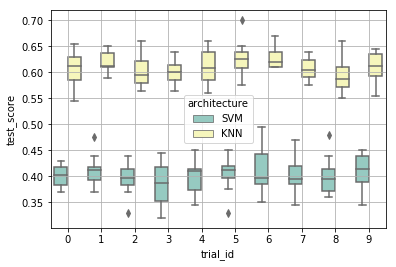

In [55]:
_ = stratified_shuffle_cv_experiment.boxplot_best_models_by_trial()

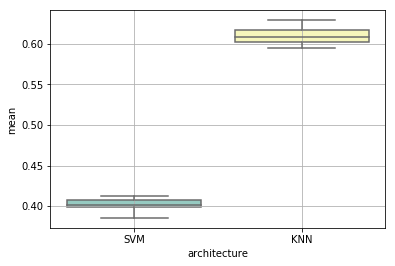

In [56]:
_ = stratified_shuffle_cv_experiment.boxplot_best_models()

# Evaluate different shallow architectures under different experimental setups